# MoMi 2023 reproduction example (TMS-EEG evoked responses)

This example reproduces the main simulation and fitting steps from:

- Momi D, Wang Z, Griffiths JD. 2023. TMS-EEG evoked responses are driven by
  recurrent large-scale network dynamics. eLife 12:e83232.

**Overview**

- Loads structural connectivity (SC), inter-regional distances, leadfield, and EEG.
- Builds a whole-brain network of Jansen–Rit neural masses with delayed coupling.
- Projects simulated source activity to EEG via a leadfield and fits model
  parameters to empirical data using gradient-based optimization.
- Reports functional connectivity correlations and cosine similarity during train/test.

**Data Dependencies**

Create a folder named `reproduce_Momi_et_al_2022` alongside this file, then place:
1) Required data from:
   https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF
2) The `fsaverage` folder from:
   https://drive.google.com/drive/folders/1YPyf3h9YKnZi0zRwBwolROQuqDtxEfzF?usp=sharing
3) Individual leadfield matrices from:
   https://drive.google.com/drive/folders/11jOvrzupbm2W8QdKTa9gPeG2Ivk4BdMN?usp=sharing

Make sure to update `files_dir` below if your paths differ.

**Quickstart**

- Ensure `brainstate`, `brainunit`, `brainmass`, and `braintools` are installed.
- Set the simulation step with `brainstate.environ.set(dt=...)` (already done here).
- Run `train_one_subject(0)` at the bottom to fit and evaluate a single subject.

**Notes on Units**

This script uses `brainunit` to carry physical units at runtime. When passing
arrays as inputs/parameters, ensure you attach appropriate units, e.g. `u.Hz`,
`u.mV`, or `u.second`. The code frequently splits mantissa and unit internally
to keep transforms numerically stable while preserving dimensions.

## Data

Create a folder named "reproduce_Momi_et_al_2022" in the same directory as this notebook.


1. Download the required data folder at:

https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF

and move the data inside ``reproduce_Momi_et_al_2022`` directory.

2. Download the fsaverage folder at:

https://drive.google.com/drive/folders/1YPyf3h9YKnZi0zRwBwolROQuqDtxEfzF?usp=sharing

and move the `fsaverage` folders inside ``reproduce_Momi_et_al_2022`` directory.


3. Please download the individual leadfield matrix at:

https://drive.google.com/drive/folders/11jOvrzupbm2W8QdKTa9gPeG2Ivk4BdMN?usp=sharing

and replate the path in the ``reproduce_Momi_et_al_2022/leadfield_from_mne`` directory.

## Models

In [1]:
import functools
from typing import Callable

import brainstate
import brainunit as u
import jax.numpy as jnp
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics.pairwise import cosine_similarity

import brainmass
import braintools
import matplotlib.pyplot as plt

In [2]:
class Scale:
    """Smoothly saturating scaling nonlinearity with unit support.

    Applies a pointwise nonlinearity `fn` (default: `tanh`) to the input after
    scaling by `slope`, then rescales back by `slope`. If the input carries
    `brainunit` units, they are preserved.

    Parameters
    ----------
    slope : float
        Controls the dynamic range; larger values reduce saturation.
    fn : Callable, optional
        Elementwise nonlinearity, defaults to `jax.numpy.tanh`.
    """
    def __init__(self, slope: float, fn: Callable = jnp.tanh):
        self.slope = slope
        self.fn = fn

    def __call__(self, x):
        x, unit = u.split_mantissa_unit(x)
        return u.maybe_decimal(self.slope * self.fn(x / self.slope) * unit)



In [4]:
class EEGLeadFieldModel(brainstate.nn.Module):
    """Linear EEG forward model.

    Projects simulated source activity to sensor space using a leadfield matrix
    `lm` and subtracts a per-channel shift/baseline `shift`.

    Parameters
    ----------
    lm : ArrayLike
        Leadfield matrix mapping sources -> sensors. Shape: [n_sources, n_sensors].
    shift : ArrayLike
        Baseline or DC offset per EEG channel. Shape: [n_sensors].
    """
    def __init__(self, lm, shift):
        super().__init__()
        self.lm = lm
        self.shift = shift

    def update(self, x):
        """Apply forward model: source `x` to EEG, then subtract shift."""
        return x @ self.lm - self.shift



In [5]:
class Network(brainstate.nn.Module):
    """Whole-brain Jansen–Rit network with delayed coupling and EEG projection.

    - Each node is a Jansen–Rit neural mass with parameters that can be
      optimized via `Parameter` wrappers.
    - Long-range coupling is derived from structural connectivity (SC), scaled
      through a learned weight matrix and normalized for stability.
    - Axonal conduction delays are computed from pairwise distances and a
      lower-bound conduction velocity.
    - Source activity is projected to EEG via an `EEGLeadFieldModel`.

    Parameters
    ----------
    sc : ndarray
        Structural connectivity matrix. Shape: [n_nodes, n_nodes].
    dist : ndarray
        Inter-node distances used to derive delays. Shape: [n_nodes, n_nodes].
    lm : Quantity
        Leadfield matrix, with appropriate units; sources -> sensors.
    w_bb : ArrayLike
        Effective log-weights; exponentiated and applied to SC in `effective_sc`.
    lm_shift : ArrayLike
        Per-channel EEG baseline shift.
    gc : float
        Global coupling gain.
    Ae, Ai, be, bi, C, a1..a4, s_max, v0, r : various
        Jansen–Rit model parameters. Can be wrapped in `Parameter` to learn.
    std_in : Quantity
        Input noise level to the excitatory population.
    var_init, mom_init : Callable
        Initializers for state variables and their velocities.
    conduct_lb : float
        Lower bound on conduction velocity (m/s) for computing delays.
    """
    def __init__(
        self,
        sc: np.ndarray,
        dist: np.ndarray,
        lm: u.Quantity,
        w_bb: brainstate.typing.ArrayLike,
        lm_shift: brainstate.typing.ArrayLike,
        gc=1e3,

        # node parameters
        Ae=3.25 * u.mV,  # Excitatory gain
        Ai=22. * u.mV,  # Inhibitory gain
        be=100. / u.second,  # Excit. time const
        bi=50. / u.second,  # Inhib. time const.
        C=135.,  # Connect. const.
        a1=1.,  # Connect. param.
        a2=0.8,  # Connect. param.
        a3=0.25,  # Connect. param
        a4=0.25,  # Connect. param.
        s_max=5. * u.Hz,  # Max firing rate
        v0=6. * u.mV,  # Firing threshold
        r=0.56,
        std_in=150. * u.Hz,
        var_init: Callable = braintools.init.Uniform(0., 5.0, unit=u.mV),
        mom_init: Callable = braintools.init.Uniform(0., 5.0, unit=u.mV / u.second),
        conduct_lb: float = 1.5,  # lower bound for conduct velocity
    ):
        super().__init__()

        self.w_bb = w_bb
        self.sc = sc
        self.gc = gc

        self.hidden_size = sc.shape[0]
        self.output_size = lm.shape[1]
        delay_time = dist / conduct_lb * brainstate.environ.get_dt()
        delay_indices = np.expand_dims(np.arange(self.hidden_size), axis=0)
        delay_indices = np.tile(delay_indices, (self.hidden_size, 1))

        self.node = brainmass.JansenRitModel(
            in_size=sc.shape[0],
            Ae=Ae,
            Ai=Ai,
            be=be,
            bi=bi,
            C=C,
            a1=a1,
            a2=a2,
            a3=a3,
            a4=a4,
            s_max=s_max,
            v0=v0,
            r=r,
            M_init=var_init,
            E_init=var_init,
            I_init=var_init,
            Mv_init=mom_init,
            Ev_init=mom_init,
            Iv_init=mom_init,
            noise_E=brainmass.GaussianNoise(sc.shape[0], sigma=std_in),
            fr_scale=Scale(5e2),
        )
        self.delay_E = brainstate.nn.StateWithDelay(self.node, 'E', init=var_init)
        self.delay_E.register_entry('d', delay_time, delay_indices)
        self.leadfield = EEGLeadFieldModel(lm, lm_shift)

    def effective_sc(self):
        """Compute the effective, symmetric, normalized coupling matrix.

        Steps
        -----
        - Exponentiate learned log-weights and multiply by SC.
        - Symmetrize via average with transpose and take `log1p`.
        - Normalize by Frobenius norm to keep coupling well-scaled.
        """
        w = u.math.exp(self.w_bb) * self.sc
        w2 = u.math.log1p((w + w.T) / 2)
        w_n = w2 / u.math.linalg.norm(w2)
        return w_n

    def update_step(self, conn, E_delayed_inp, E_inp):
        """Single integration step within a duration window.

        Accumulates delayed inputs and global inhibitory feedback, then steps
        the Jansen–Rit node dynamics.
        """
        E_inp = E_inp + E_delayed_inp - self.gc * self.node.E.value * u.math.sum(conn, axis=1)
        self.node(E_inp=E_inp)

    def update_duration(self, conn, E_inp_duration, index):
        """Integrate a full duration segment for a given batch index.

        Parameters
        ----------
        conn : Quantity
            Effective coupling matrix with units [Hz/mV].
        E_inp_duration : Quantity
            Input over a duration. Shape: [n_time_per_duration, n_nodes].
        index : int
            Absolute starting time index of the duration (for state context).
        """
        with brainstate.environ.context(i=index):
            E_delayed_inp = brainmass.additive_coupling(self.delay_E.at('d'), conn, self.gc)
            brainstate.transform.for_loop(
                functools.partial(self.update_step, conn, E_delayed_inp),
                E_inp_duration
            )
            self.delay_E.update(self.node.E.value)
            return {
                'M': self.node.M.value,
                'I': self.node.I.value,
                'E': self.node.E.value,
                'Mv': self.node.Mv.value,
                'Ev': self.node.Ev.value,
                'Iv': self.node.Iv.value,
                'eeg': self.leadfield(self.node.eeg()),
            }

    def update_batch(self, i_duration_start, E_inp_batch):
        """Integrate a batch of consecutive duration segments.

        Parameters
        ----------
        i_duration_start : int
            Absolute starting duration index for the batch.
        E_inp_batch : Quantity
            Batched input. Shape: [n_duration, n_time_per_duration, n_nodes].
        """
        conn = self.effective_sc() * u.Hz / u.mV
        return brainstate.transform.for_loop(
            functools.partial(self.update_duration, conn),
            E_inp_batch,
            i_duration_start + np.arange(E_inp_batch.shape[0])
        )



## Trainer

In [6]:
class ModelFitting:
    """Trainer for the whole-brain network using batched time windows.

    Splits data into fixed-length duration segments and runs gradient-based
    optimization over model parameters to match empirical EEG in sensor space.

    Parameters
    ----------
    model : Network
        The whole-brain model to train.
    optimizer : braintools.optim.Optimizer
        Optimizer to update registered trainable parameters.
    duration_per_batch : Quantity
        Total simulated time per optimization batch (e.g., 50 ms).
    time_per_duration : Quantity
        Duration of a single integration window within a batch.
    grad_clip : float
        Gradient norm clipping value.
    """
    def __init__(
        self,
        model: Network,
        optimizer: braintools.optim.Optimizer,
        duration_per_batch: u.Quantity,
        time_per_duration: u.Quantity,
        grad_clip: float = 1.0,
    ):
        self.model = model
        self.optimizer = optimizer
        self.weights = self.model.states(brainstate.ParamState)
        self.optimizer.register_trainable_weights(self.weights)
        self.cost = DistCost()

        dt = brainstate.environ.get_dt()
        self.n_duration_per_batch = int(duration_per_batch / time_per_duration)
        self.n_time_per_duration = int(time_per_duration / dt)
        self.grad_clip = grad_clip

    @brainstate.transform.jit(static_argnums=0)
    def _batch_train(self, i_duration, inputs, targets):
        """Train on a single batch of duration segments.

        inputs : [n_duration, n_time_per_duration, n_nodes]
        targets: [n_duration, n_time_per_duration, n_channels]
        Returns: (loss, outputs dict)
        """

        def f_loss():
            out = self.model.update_batch(i_duration, inputs)
            loss_ = self.cost(out['eeg'], targets)
            return loss_, out

        f_grad = brainstate.transform.grad(f_loss, grad_states=self.weights, return_value=True, has_aux=True)
        grads, loss, out_batch = f_grad()
        grads = brainstate.functional.clip_grad_norm(grads, self.grad_clip)
        # jax.debug.print("Gradients = {g}", g=jax.tree.map(lambda x: jnp.max(jnp.abs(x)), grads))
        self.optimizer.update(grads)
        return loss, out_batch

    def train(
        self,
        data: u.Quantity,
        uuu: u.Quantity,
        n_epoch: int,
    ):
        """Train using the logic of `model_fit_LM.py` from the paper code.

        Parameters
        ----------
        data : Quantity
            Empirical EEG in sensor space. Shape: [n_time, n_channels].
        uuu : Quantity
            Input stimulation per node. Shape: [n_time, n_nodes].
        n_epoch : int
            Maximum number of epochs.
        """
        brainstate.nn.init_all_states(self.model)

        # define masks for getting lower triangle matrix
        mask = np.tril_indices(self.model.hidden_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        duration = self.n_duration_per_batch
        num_batches = int(data.shape[0] / duration)

        for i_epoch in range(n_epoch):
            losses = []
            output_eeg = []
            for i_batch in range(num_batches):
                inputs = uuu[i_batch * duration:(i_batch + 1) * duration]
                targets = data[i_batch * duration:(i_batch + 1) * duration]
                loss, out_batch = self._batch_train(i_batch, inputs, targets)
                output_eeg.append(out_batch['eeg'])
                losses.append(loss)

            # Calculate metrics like model_fit_LM.py
            fc = np.corrcoef(u.get_mantissa(data.T))
            ts_sim = u.get_magnitude(u.math.concatenate(output_eeg, axis=0))
            fc_sim = np.corrcoef(ts_sim[10:].T)  # Skip first 10 timepoints
            corr = u.math.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1]
            cos_sim = u.math.diag(cosine_similarity(ts_sim.T, u.get_magnitude(data.T))).mean()

            print(
                f'epoch {i_epoch}, '
                f'loss = {np.mean(losses)}, '
                f'pearson correlation = {corr}, '
                f'cosine similarity = {cos_sim}'
            )

    @brainstate.transform.jit(static_argnums=0)
    def _batch_predict(self, i_duration, inputs):
        """Forward-only prediction for a batch of duration segments.

        inputs: [n_duration, n_time_per_duration, n_nodes]
        """
        return self.model.update_batch(i_duration, inputs)

    def test(
        self,
        uuu: u.Quantity,
        base_batch_num: int = 20,
        data: np.ndarray = None,
    ):
        """Evaluate trained model, mirroring `model_fit_LM.py` behavior.

        Parameters
        ----------
        uuu : Quantity
            Input stimulation [n_time, n_nodes]. Baseline segments are added
            internally for state warmup.
        base_batch_num : int
            Number of baseline batches (no stimulation) prepended before the
            actual input, allowing network states to settle.
        data : ndarray, optional
            Empirical EEG [n_time, n_channels] to compute FC correlation and
            cosine similarity against simulated outputs. If None, only
            simulation is returned/printed.
        """
        duration = self.n_duration_per_batch
        transient_num = 10  # Skip first 10 timepoints like model_fit_LM.py

        # Initialize model with specific initial conditions
        brainstate.nn.init_all_states(self.model)

        eeg_all = []

        # Create extended input like model_fit_LM.py:
        # u_hat has extra baseline batches + actual data
        total_time_steps = base_batch_num * duration + uuu.shape[0]
        u_hat = np.zeros((total_time_steps, *uuu.shape[1:])) * uuu.unit
        u_hat[base_batch_num * duration:] = uuu  # Put actual input after baseline

        # Calculate total number of batches (baseline + actual)
        total_batches = int(total_time_steps / duration)

        # Process in batches like model_fit_LM.py
        for i_batch in range(total_batches):
            start_idx = i_batch * duration
            end_idx = (i_batch + 1) * duration

            # Get batch input and reshape to [n_duration, n_time, n_input]
            batch_input = u_hat[start_idx:end_idx]

            # Run model prediction (no gradients needed for test)
            out_batch = self._batch_predict(start_idx, batch_input)

            # Only collect outputs after baseline batches (like model_fit_LM.py)
            if i_batch >= base_batch_num:
                eeg_all.append(out_batch['eeg'])

        # Compute correlation metrics like model_fit_LM.py
        if data is not None:
            ts_sim = u.get_magnitude(u.math.concatenate(eeg_all, axis=0))
            fc_sim = np.corrcoef(ts_sim[transient_num:].T)  # Skip transients
            fc_emp = np.corrcoef(u.get_mantissa(data.T))

            mask_e = np.tril_indices(self.model.output_size, -1)
            corr = np.corrcoef(fc_sim[mask_e], fc_emp[mask_e])[0, 1]
            cos_sim = np.diag(cosine_similarity(ts_sim.T, u.get_magnitude(data.T))).mean()
            print(f'Test - Pearson correlation: {corr:.3f}, Cosine similarity: {cos_sim:.3f}')


## Loss Function

In [7]:
class DistCost:
    """Root-mean-square distance in sensor space.

    Returns an RMSE-like measure between simulated and empirical EEG
    time-series. Units are stripped to compute the scalar distance on mantissas.
    """
    def __call__(self, sim, emp):
        return u.get_mantissa(u.math.sqrt(u.math.mean((sim - emp) ** 2)))

## Training

In [8]:
files_dir = 'D:/codes/githubs/computational_neuroscience/PyTepFit/reproduce_Momi_et_al_2022'
sc_file = files_dir + '/Schaefer2018_200Parcels_7Networks_count.csv'
high_file = files_dir + '/only_high_trial.mat'
dist_file = files_dir + '/Schaefer2018_200Parcels_7Networks_distance.csv'
file_leadfield = files_dir + '/leadfield'
file_eeg = files_dir + '/real_EEG'
eeg = np.load(file_eeg, allow_pickle=True)
eeg

array([[-0.04882562, -0.01855596,  0.0080311 , ...,  0.06746994,
         0.07579786,  0.0950077 ],
       [-0.05753722, -0.04972065, -0.05058948, ...,  0.12024794,
         0.10780556,  0.09364477],
       [-0.04663963, -0.02801384, -0.01127495, ...,  0.07189867,
         0.07543082,  0.08844396],
       ...,
       [ 0.11301994,  0.13689921,  0.15957486, ..., -0.07983613,
        -0.08232486, -0.09218773],
       [ 0.05367654,  0.01649795, -0.01004933, ...,  0.05334642,
         0.02660085, -0.00436937],
       [ 0.01670002, -0.01413833, -0.03701906, ...,  0.04310367,
         0.02319151,  0.0047153 ]], shape=(62, 2000))

In [9]:
eeg.shape

(62, 2000)

In [10]:
lm = np.load(file_leadfield, allow_pickle=True)

In [11]:
lm.shape

(62, 200)

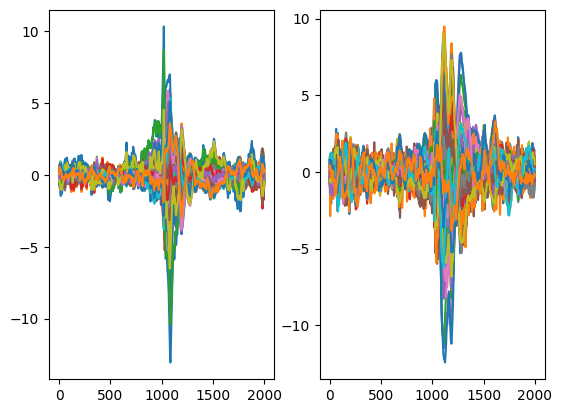

In [12]:
data_high = scipy.io.loadmat(high_file)
fig, ax = plt.subplots(1, 2)
ax[0].plot(data_high['only_high_trial'][0].T)
ax[1].plot(data_high['only_high_trial'][6].T)
plt.show()

In [13]:
data_high['only_high_trial'].shape

(20, 62, 2000)

In [14]:
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values

sc = 0.5 * (sc + sc.T)
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))

In [15]:
sc.shape

(200, 200)

In [16]:
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

In [17]:
dist.shape

(200, 200)

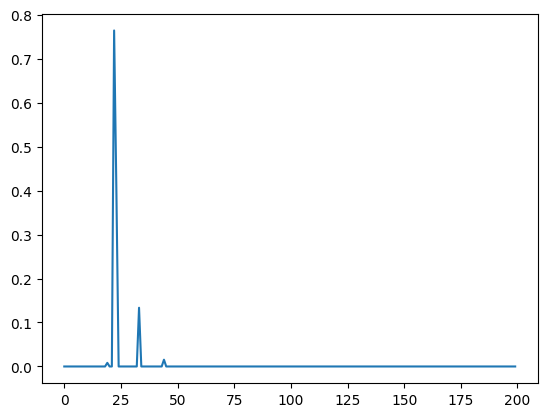

In [18]:
stim_weights_file = files_dir + '/stim_weights.npy'
stim_weights = np.load(stim_weights_file)

plt.plot(stim_weights)
plt.show()

In [19]:
stim_weights.shape

(200,)

In [20]:
node_size = stim_weights.shape[0]
output_size = lm.shape[0]
n_duration_per_batch = 50
num_epoches = 120
duration_length = 0.001 * u.second
step_size = 0.0001 * u.second
n_time_per_duration = int(duration_length / step_size)


In [21]:
brainstate.environ.set(dt=step_size)

In [22]:
def train_one_subject(sub_index):
    """Fit and evaluate the model for a single subject.

    Steps
    -----
    1) Load subject-specific EEG and leadfield, center and scale leadfield.
    2) Instantiate the whole-brain network with learnable parameters.
    3) Optimize parameters using batched time windows and simple stimulation.
    4) Evaluate Pearson FC correlation and cosine similarity on held-out data.

    Parameters
    ----------
    sub_index : int
        Zero-based subject index to select EEG and leadfield.
    """
    print(f'sub: {sub_index}')
    data_mean = np.array(data_high['only_high_trial'][sub_index]).T * u.mV
    # data_mean: [n_time, n_channel], [2000, 62]

    lm = np.load(f'{files_dir}/leadfield_from_mne/sub{str(sub_index + 1).zfill(3)}/leadfield.npy', allow_pickle=True)
    lm = lm - u.math.mean(lm, axis=0, keepdims=True)
    lm = lm.T * 0.0005

    net = Network(
        sc=sc,
        w_bb=braintools.param.Param(sc + 0.05),
        dist=dist,
        lm=braintools.param.Param(lm),
        lm_shift=braintools.param.Param(np.random.normal(2.0, 0.5, output_size) * u.mV),

        # Ae=braintools.param.Param(3.25 * u.mV, braintools.param.Sigmoid(2 * u.mV, 10 * u.mV)),
        # Ai=braintools.param.Param(22. * u.mV, braintools.param.Sigmoid(17.0 * u.mV, 110 * u.mV)),
        # be=braintools.param.Param(100. * u.Hz, braintools.param.Sigmoid(5.0 * u.Hz, 150. * u.Hz)),
        # bi=braintools.param.Param(50. * u.Hz, braintools.param.Sigmoid(25.0 * u.Hz, 75 * u.Hz)),
        # a1=braintools.param.Param(1.0, braintools.param.Sigmoid(0.5, 1.5)),
        # a2=braintools.param.Param(0.8, braintools.param.Sigmoid(0.4, 1.2)),
        # a3=braintools.param.Param(0.25, braintools.param.Sigmoid(0.125, 0.375)),
        # a4=braintools.param.Param(0.25, braintools.param.Sigmoid(0.125, 0.375)),
        # gc=braintools.param.Param(1e3, braintools.param.Sigmoid(10, 2e3)),

        Ae=braintools.param.Param(3.25 * u.mV, braintools.param.Softplus(1.0 * u.mV)),
        Ai=braintools.param.Param(22. * u.mV, braintools.param.Softplus(1.0 * u.mV)),
        be=braintools.param.Param(100. * u.Hz, braintools.param.Softplus(1.0 * u.Hz)),
        bi=braintools.param.Param(50. * u.Hz, braintools.param.Softplus(1.0 * u.Hz)),
        a1=braintools.param.Param(1.0, braintools.param.Softplus(0.01)),
        a2=braintools.param.Param(0.8, braintools.param.Softplus(0.01)),
        a3=braintools.param.Param(0.25, braintools.param.Softplus(0.01)),
        a4=braintools.param.Param(0.25, braintools.param.Softplus(0.01)),
        gc=braintools.param.Param(1e3, braintools.param.Softplus(1e2)),
        std_in=braintools.param.Param(10 * u.Hz, braintools.param.Softplus(0.0 * u.Hz)),

        # Ae=braintools.param.Param(3.25 * u.mV),
        # Ai=braintools.param.Param(22. * u.mV),
        # be=braintools.param.Param(100. * u.Hz),
        # bi=braintools.param.Param(50. * u.Hz),
        # a1=braintools.param.Param(1.0),
        # a2=braintools.param.Param(0.8),
        # a3=braintools.param.Param(0.25),
        # a4=braintools.param.Param(0.25),
        # gc=braintools.param.Param(1e3),

        s_max=5.0 * u.Hz,
        v0=6.0 * u.mV,
        r=0.56,
        conduct_lb=2.5,
    )

    fitter = ModelFitting(
        net,
        optimizer=braintools.optim.Adam(5e-2),  # Match model_fit_LM.py learning rate
        duration_per_batch=n_duration_per_batch * duration_length,
        time_per_duration=duration_length,
    )

    # Create input stimulation like model_fit_LM.py: [n_time, n_nodes]
    uuu = np.zeros((400, n_time_per_duration, node_size)) * u.Hz  # [n_time, n_nodes]
    uuu[110:120] = 1000. * u.Hz  # Stimulation from time 110 to 120
    uuu = uuu * stim_weights
    fitter.train(data_mean[900:1300], uuu, n_epoch=100)

    # Test with same stimulation
    uuu_test = np.zeros((400, n_time_per_duration, node_size)) * u.Hz
    uuu_test[110:120] = 1000. * u.Hz
    uuu_test = uuu_test * stim_weights
    fitter.test(uuu_test, base_batch_num=20, data=data_mean[900:1300])

In [23]:
train_one_subject(0)

sub: 0
epoch 0, loss = 460.078125, pearson correlation = 0.20935148000717163, cosine similarity = 0.04663469269871712
epoch 1, loss = 38.834983825683594, pearson correlation = 0.13886907696723938, cosine similarity = 0.05299335718154907
epoch 2, loss = 42.45254135131836, pearson correlation = 0.1607246696949005, cosine similarity = -0.025713831186294556
epoch 3, loss = 67.21541595458984, pearson correlation = 0.11382129043340683, cosine similarity = 0.18167605996131897
epoch 4, loss = 12.551870346069336, pearson correlation = 0.08443965762853622, cosine similarity = 0.037764620035886765
epoch 5, loss = 7.842024803161621, pearson correlation = 0.0801437646150589, cosine similarity = -0.12780827283859253
epoch 6, loss = 3.6760470867156982, pearson correlation = 0.05815885215997696, cosine similarity = 0.029248055070638657
epoch 7, loss = 3.675583839416504, pearson correlation = 0.17223167419433594, cosine similarity = -0.039724159985780716
epoch 8, loss = 2.2407851219177246, pearson corr